In [10]:
from src.mitnanex import run
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [11]:

clusters_list = run()

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in clusters_list.clusters],
        "repr_read_len": [i.longest_read_length for i in clusters_list.clusters],
        "id_longest_read": [i.longest_read_id for i in clusters_list.clusters],
        "id_cluster":[i.id_cluster for i in clusters_list.clusters],
    }
)

In [12]:
# Test on the first 30 clusters
import math
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
3,4,39243,SRR5892449.10138,4
21,11,29533,SRR5892449.13231,22
69,2,23104,SRR5892449.14249,70
57,5,23987,SRR5892449.15079,58
37,5,26110,SRR5892449.15090,38


# Coverage

The first step is to filter the reads by coverage. For that I will explore the use of Kernel Density since this is clusters_list one dimensional clustering.

In [13]:
clusters['transform'] = [math.log2(i)for i in clusters['coverage']]
clusters.sort_values('coverage',ascending=False, inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster,transform
11,48,33518,SRR5892449.9739,12,5.584963
25,40,28027,SRR5892449.37390,26,5.321928
13,28,32839,SRR5892449.22604,14,4.807355
68,23,23206,SRR5892449.36605,69,4.523562
71,23,23009,SRR5892449.45685,72,4.523562


<Axes: >

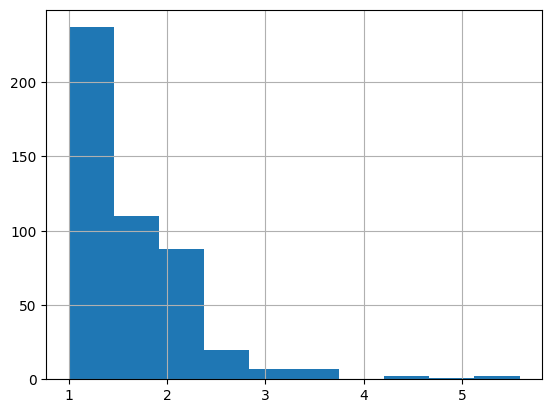

In [14]:
clusters['transform'].hist()

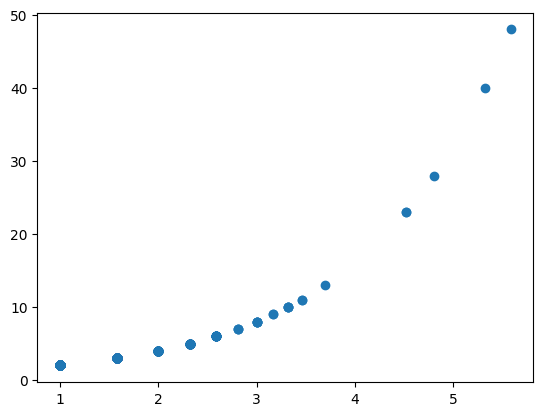

In [15]:
plt.scatter(x=clusters['transform'], y=clusters['coverage'])

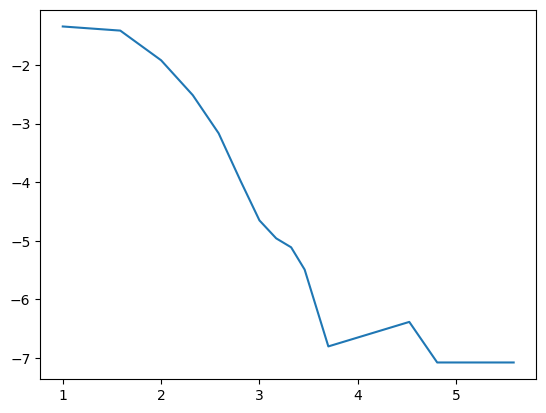

In [16]:
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(clusters['coverage'].array.reshape(-1,1))
cov_fdp = kde.score_samples(clusters['coverage'].array.reshape(-1,1))
plt.plot(clusters['transform'], cov_fdp)

In [17]:
from scipy.signal import argrelextrema
import numpy as np
local_min = argrelextrema(cov_fdp, np.less)[0]
min_coverage = clusters.iloc[max(local_min),:]['coverage']
print("Covertura minima admitida: ", min_coverage)

Covertura minima admitida:  13


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create clusters_list script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [18]:
from src.utils import get_sequences_by_id, convert_fq_to_fa, write_fasta
from src.kmer_cnt import count_kmer

In [19]:
convert_fq_to_fa('test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted_reversed.fastq','test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted_reversed.fasta')

11637 sequences converted to fasta


'test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted_reversed.fasta'

In [20]:
fasta = 'test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted_reversed.fasta'
repr_reads = [i for i in clusters['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [21]:
## Get the real mt sequences
with open('test/list_ids_reads_mt.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[1:] for i in ids_mt]

In [22]:
hist_df= pd.DataFrame(hist)
hist_df.rename(columns={hist_df.iloc[:,-1].name:'ids'}, inplace=True)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,ids
0,0.068673,0.062148,0.036930,0.042465,0.053846,0.038121,0.039734,0.035885,0.030479,0.022378,...,0.010410,0.018492,0.010923,0.048458,0.018804,0.028591,0.024485,0.014772,0.022030,SRR5892449.19157
1,0.068851,0.054718,0.038194,0.043581,0.053848,0.029014,0.039015,0.038870,0.033290,0.026308,...,0.012369,0.018094,0.012900,0.045731,0.020027,0.032275,0.027854,0.018964,0.019423,SRR5892449.8608
2,0.071796,0.061532,0.038105,0.046099,0.053462,0.037827,0.039038,0.035230,0.031573,0.020956,...,0.009759,0.019166,0.011046,0.047486,0.019569,0.028068,0.025849,0.014173,0.021461,SRR5892449.16681
3,0.059530,0.052343,0.036926,0.039168,0.043934,0.036161,0.039576,0.037486,0.028465,0.028134,...,0.014245,0.022196,0.016411,0.044392,0.024311,0.028796,0.028924,0.018042,0.021737,SRR5892449.10138
4,0.091905,0.144754,0.025032,0.025625,0.181387,0.027713,0.028461,0.022506,0.022222,0.013199,...,0.005568,0.006213,0.002862,0.026940,0.006754,0.024439,0.006909,0.004692,0.011292,SRR5892449.27537


# Dimensionality reduction with PCA and clustering with k-means 

In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [24]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [25]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([1.83929842e-03, 5.22679318e-05])

In [53]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction, columns=['comp1', 'comp2'])

## merging the dataframe with ids and other relevant information
kmer_reduction ['ids'] = hist_df['ids']
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
kmer_reduction['mt'] = (kmer_reduction['ids'].isin(ids_mt).astype(int) + 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage'] > min_coverage]
kmer_reduction

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt
11,0.115703,0.014906,SRR5892449.9739,48,33518,12,5.584963,32
13,0.238209,0.001286,SRR5892449.22604,28,32839,14,4.807355,32
25,-0.006677,0.005612,SRR5892449.37390,40,28027,26,5.321928,1
68,0.214023,-0.008418,SRR5892449.36605,23,23206,69,4.523562,32
71,0.273784,0.009953,SRR5892449.45685,23,23009,72,4.523562,32


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'comp2')

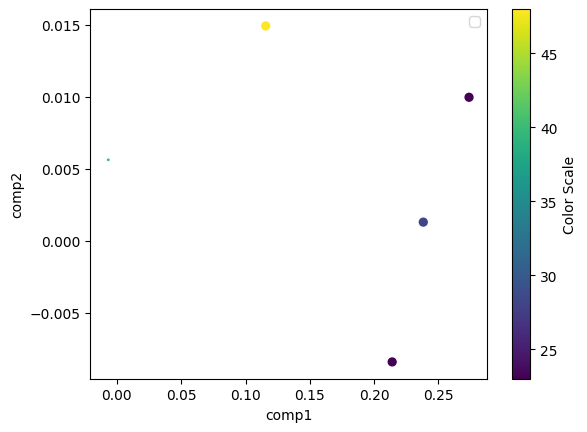

In [54]:
sc = plt.scatter(kmer_reduction['comp1'],kmer_reduction['comp2'], c=kmer_reduction['coverage'], s=kmer_reduction['mt'])
# legend
# Add clusters_list colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()
plt.xlabel('comp1')
plt.ylabel('comp2')

In [55]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
mt_prediction = kmeans.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
kmer_reduction['cluster_prediction'] = mt_prediction

Initialization complete
Iteration 0, inertia 0.014798743240910312.
Iteration 1, inertia 0.014086650707374623.
Converged at iteration 1: strict convergence.


Text(0, 0.5, 'comp2')

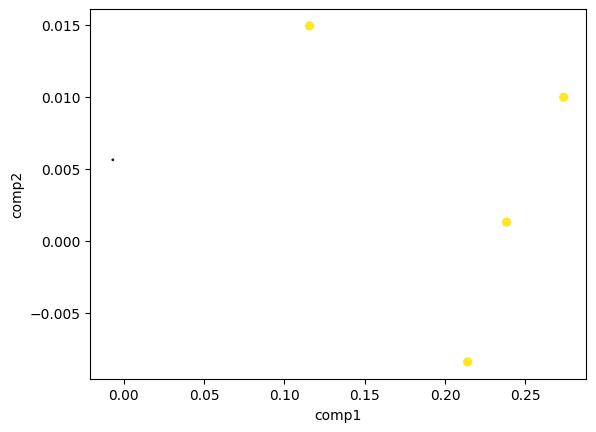

In [56]:
plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=kmer_reduction['mt'])
plt.xlabel('comp1')
plt.ylabel('comp2')

# Get the cluster of interest

This step is clusters_list pain in the ass, but since I am looking to keep the free-reference. 

In [57]:
selected_cluster_id = kmer_reduction.loc[:, kmer_reduction.columns != 'ids'].groupby(by='cluster_prediction')['coverage'].mean().idxmax()
selected_cluster = kmer_reduction[kmer_reduction['cluster_prediction'] == selected_cluster_id]
selected_cluster.head()

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt,cluster_prediction
25,-0.006677,0.005612,SRR5892449.37390,40,28027,26,5.321928,1,0


In [58]:
sequences_ids = set()
for i in selected_cluster['id_cluster']:
    sequences_ids.update(clusters_list.get_cluster(i).id_sequences)
write_fasta(fasta=fasta, sequences_ids=sequences_ids, output='test/mt_reads_v1.fasta')

40 reads retrieved
